In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
import skimage.io
import skimage.transform
import scipy.ndimage
from old_optical_flow import flow_iterative # change to optical_flow
from functools import partial
import imageio

In [2]:

def compute_flow_our(f1, f2):

    c1 = np.minimum(
        1, 1 / 5 * np.minimum(np.arange(f1.shape[0])[:, None], np.arange(f1.shape[1]))
    )
    c1 = np.minimum(
        c1,
        1 / 5 * np.minimum(
            f1.shape[0] - 1 - np.arange(f1.shape[0])[:, None],
            f1.shape[1] - 1 - np.arange(f1.shape[1]),
        ),
    )
    c2 = c1

    n_pyr = 4

    opts = dict(
        sigma=4.0,
        sigma_flow=4.0,
        num_iter=3,
        model="constant",
        mu=0.1,
    )

    d = None

    for pyr1, pyr2, c1_, c2_ in reversed(
    list(
        zip(
            *list(
                map(
                    partial(skimage.transform.pyramid_gaussian, max_layer=n_pyr),
                    [f1, f2, c1, c2],
                    )
                )
            )
        )
    ):
        if d is not None:
            d = skimage.transform.pyramid_expand(d, channel_axis=-1)
            d = d[: pyr1.shape[0], : pyr2.shape[1]] * 2
        d = flow_iterative(pyr1, pyr2, c1=c1_, c2=c2_, d=d, **opts)

    return d

def compute_flow_cv(f1, f2):
    gray1 = cv2.cvtColor(f1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(f2, cv2.COLOR_BGR2GRAY)
    opts_cv = dict(
        pyr_scale=0.5,
        levels=6,
        winsize=25,
        iterations=3,
        poly_n=25,
        poly_sigma=3.0,
        # flags=0
        flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN,
    )

    d2 = cv2.calcOpticalFlowFarneback(
            gray2, gray1, None, **opts_cv
        )
    d2 = -d2[..., (1, 0)]

    return d2

def get_flow_viz(flow):
    """ Obtains BGR image to Visualize the Optical Flow 
        """
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
    hsv[..., 1] = 255

    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    return rgb

def get_motion_mask(flow_mag, motion_thresh=1, kernel=np.ones((7,7))):
    """ Obtains Detection Mask from Optical Flow Magnitude
        Inputs:
            flow_mag (array) Optical Flow magnitude
            motion_thresh - thresold to determine motion
            kernel - kernal for Morphological Operations
        Outputs:
            motion_mask - Binray Motion Mask
        """
    motion_mask = np.uint8(flow_mag > motion_thresh)*255

    motion_mask = cv2.erode(motion_mask, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_CLOSE, kernel, iterations=3)
    
    return motion_mask

In [3]:
def get_contour_detections_2(mask, ang, angle_thresh=2, thresh=400):
    """ Obtains initial proposed detections from contours discoverd on the
        mask. Scores are taken as the bbox area, larger is higher.
        Inputs:
            mask - thresholded image mask
            angle_thresh - threshold for flow angle standard deviation
            thresh - threshold for contour size
        Outputs:
            detectons - array of proposed detection bounding boxes and scores 
                        [[x1,y1,x2,y2,s]]
        """
    # get mask contours
    contours, _ = cv2.findContours(mask, 
                                   cv2.RETR_EXTERNAL, # cv2.RETR_TREE, 
                                   cv2.CHAIN_APPROX_TC89_L1)
    temp_mask = np.zeros_like(mask) # used to get flow angle of contours
    angle_thresh = angle_thresh*ang.std()
    detections = []
    for cnt in contours:
        # get area of contour
        x,y,w,h = cv2.boundingRect(cnt)
        area = w*h

        # get flow angle inside of contour
        cv2.drawContours(temp_mask, [cnt], 0, (255,), -1)
        flow_angle = ang[np.nonzero(temp_mask)]

        if (area > thresh) and (flow_angle.std() < angle_thresh): # hyperparameter
            detections.append([x,y,x+w,y+h, area])

    return np.array(detections)

In [4]:
def draw_bboxes(frame, detections):
    for det in detections:
        x1,y1,x2,y2 = det
        cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 3)

In [5]:
def create_gif_cv():
    resaults = []
    filenames = [f"./data/cars/car{i}.png" for i in range(1,15)]

    for i in range(0,13):
        path1 = filenames[i]
        path2 = filenames[i + 1]

        # OPENCV INPUT
        f1 = skimage.io.imread(path1).astype(np.uint8)[:,:,:3]
        f2 = skimage.io.imread(path2).astype(np.uint8)[:,:,:3]

        d2 = compute_flow_cv(f1, f2)
        flow2 = d2

        mag2, ang2 = cv2.cartToPolar(flow2[..., 0], flow2[..., 1])

        rgb2 = get_flow_viz(flow2)
        mask2 = get_motion_mask(mag2, motion_thresh=5)

        detections = get_contour_detections_2(mask2, ang2, angle_thresh=2, thresh=400)

        # separate bboxes and scores
        bboxes = detections[:, :4]

        f21 = f2.copy()
        draw_bboxes(f21, bboxes)

        resaults.append(f21)

    imageio.mimsave('cars_cv.gif', resaults)

In [6]:
def create_gif_our():
    resaults = []
    filenames = [f"./data/cars/car{i}.png" for i in range(1,15)]

    for i in range(0,13):
        path1 = filenames[i]
        path2 = filenames[i + 1]

        # OPENCV INPUT
        f1 = skimage.io.imread(path1).astype(np.double)
        f2 = skimage.io.imread(path2).astype(np.double)

        d2 = compute_flow_our(f1, f2)
        flow2 = d2

        mag2, ang2 = cv2.cartToPolar(flow2[..., 0], flow2[..., 1])

        rgb2 = get_flow_viz(flow2)
        mask2 = get_motion_mask(mag2, motion_thresh=14)

        detections = get_contour_detections_2(mask2, ang2, angle_thresh=2, thresh=400)

        # separate bboxes and scores
        bboxes = detections[:, :4]

        f21 = f2.copy()
        draw_bboxes(f21, bboxes)

        resaults.append(f21)

    test = list(map(lambda x: x.astype(np.uint8), resaults))

    imageio.mimsave('cars_our3.gif', test)
    return resaults

[5786016  153120]
[5907308   31828]
0.20786311389759665


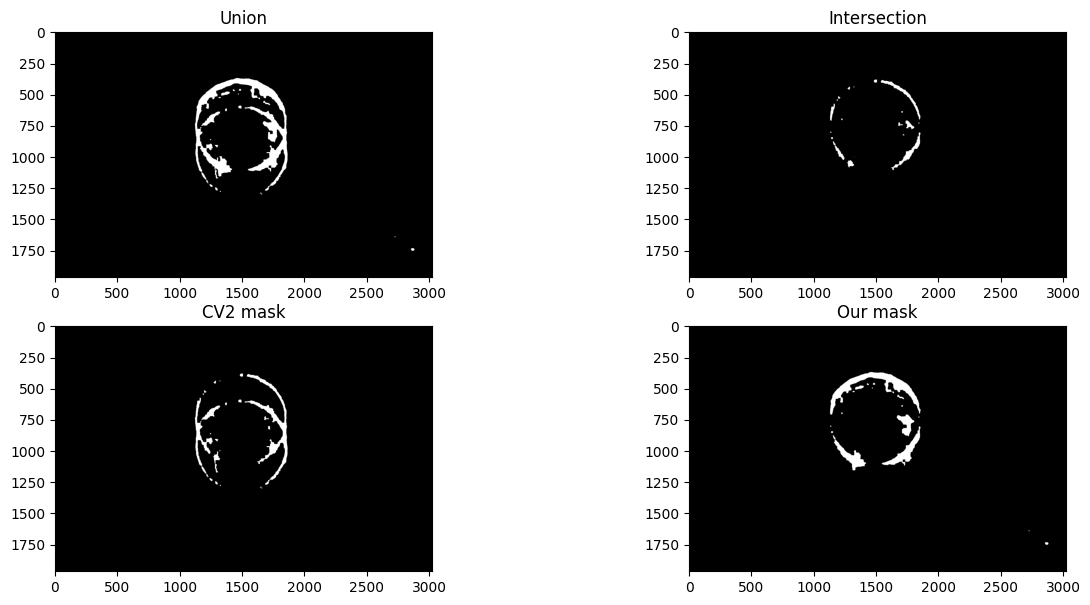

In [7]:
def IoU(image_path_1, image_path_2):
    image1_cv = skimage.io.imread(image_path_1).astype(np.uint8)[:,:,:3] # for CV2 implementation
    image2_cv = skimage.io.imread(image_path_2).astype(np.uint8)[:,:,:3] # for CV2 implementation
    image1_our = skimage.io.imread(image_path_1).astype(np.double) # for OUR implementation
    image2_our = skimage.io.imread(image_path_2).astype(np.double) # for CV2 implementation

    flow_cv = compute_flow_cv(image1_cv, image2_cv) # compute displacement field using our code
    flow_our = compute_flow_our(image1_our, image2_our) # computo displacement fiesld using cv2 code

    # Calculates magnitude and angle id 2d vectors
    mag_cv, _ = cv2.cartToPolar(flow_cv[..., 0], flow_cv[..., 1]) 
    mag_our, _ = cv2.cartToPolar(flow_our[..., 0], flow_our[..., 1])

    
    mask_cv = get_motion_mask(mag_cv, motion_thresh=0.1)
    mask_our = get_motion_mask(mag_our, motion_thresh=100)

    corrected_mask_cv = np.where(mask_cv > 0, 255, 0)
    corrected_mask_our = np.where(mask_our > 0, 255, 0)

    union = np.where(corrected_mask_our | corrected_mask_cv, 255, 0)
    intersection = np.where(corrected_mask_our & corrected_mask_cv, 255, 0)

    fig, ax = plt.subplots(2, 2, figsize=(15, 7))
    ax[0,0].set_title("Union")
    ax[0,0].imshow(union, cmap='gray')
    ax[0,1].set_title("Intersection")
    ax[0,1].imshow(intersection, cmap="gray")
    ax[1,0].set_title("CV2 mask")
    ax[1,0].imshow(mask_cv, cmap='gray')
    ax[1,1].set_title("Our mask")
    ax[1,1].imshow(mask_our, cmap="gray")

    _, counts_union = np.unique(union, return_counts=True)
    _, counts_intersection = np.unique(intersection, return_counts=True)

    iou = counts_intersection[1] / counts_union[1]

    print(iou)

IoU("./data/IoU/test5.png", "./data/IoU/test6.png")
    


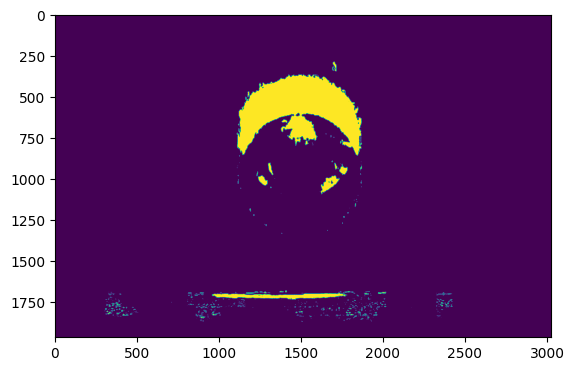

In [12]:
f11 = skimage.io.imread("./data/IoU/test5.png").astype(np.uint8)[:,:,:3]
f12 = skimage.io.imread("./data/IoU/test6.png").astype(np.uint8)[:,:,:3]
f21 = skimage.io.imread("./data/IoU/test5.png").astype(np.double)
f22 = skimage.io.imread("./data/IoU/test6.png").astype(np.double)

f11_grey = cv2.cvtColor(f11, code = cv2.COLOR_BGR2GRAY)
f12_grey = cv2.cvtColor(f12, code = cv2.COLOR_BGR2GRAY)


grayscale_diff = cv2.subtract(f11_grey, f12_grey)
res = np.where(grayscale_diff > 1, 255, 0)

plt.imshow(res)

In [6]:
import rembg
import numpy as np
from PIL import Image

# Load the input image
input_image = Image.open('./data/IoU/test5.png')

# Convert the input image to a numpy array
input_array = np.array(input_image)

# Apply background removal using rembg
output_array = rembg.remove(input_array)

# Create a PIL Image from the output array
output_image = Image.fromarray(output_array)

# Save the output image
output_image.save('output_image1.png')

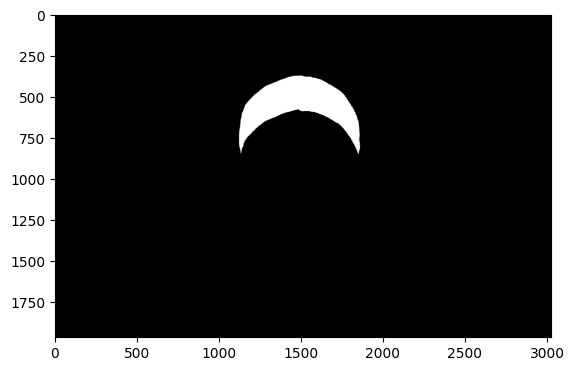

In [26]:
f11 = skimage.io.imread("./output_image1.png").astype(np.uint8)[:,:,:3]
f12 = skimage.io.imread("./output_image2.png").astype(np.uint8)[:,:,:3]

f11_grey = cv2.cvtColor(f11, code = cv2.COLOR_BGR2GRAY)
f12_grey = cv2.cvtColor(f12, code = cv2.COLOR_BGR2GRAY)

white_1 = np.where(f11_grey > 0, 255, 0)
white_2 = np.where(f12_grey > 0, 255, 0)

res = np.where(white_1 - white_2 > 0, 255, 0)

plt.imshow(res, cmap="gray")

In [100]:
images = []
filenames = [f"frame{i}.png" for i in range(1,14)]
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('cars_our.gif', images)

/var/folders/lh/rd5kzgf52pv46_540yq0yf380000gn/T/ipykernel_1454/70841956.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))
